# Определение именованных сущностей в рецептах

* [1] https://open.blogs.nytimes.com/2015/04/09/extracting-structured-data-from-recipes-using-conditional-random-fields
* [2] https://open.blogs.nytimes.com/2016/04/27/structured-ingredients-data-tagging
* [3] https://pytorch.org/tutorials/beginner/nlp/sequence_models_tutorial.html#sphx-glr-beginner-nlp-sequence-models-tutorial-py
* [4] https://pytorch.org/tutorials/beginner/saving_loading_models.html
* [5] https://en.wikipedia.org/wiki/Inside%E2%80%93outside%E2%80%93beginning_(tagging)
* [6] https://en.wikipedia.org/wiki/Named-entity_recognition

In [12]:
# Если Вы запускаете ноутбук на colab,
# выполните следующие строчки, чтобы подгрузить библиотеку dlnlputils:

# !git clone https://github.com/Samsung-IT-Academy/stepik-dl-nlp.git
import sys; sys.path.append('/Users/evagolubenko/Documents/try_python/sumsung-dl-nlp_(stepik)/')

In [ ]:
# Для выполнения этого задания не забудьте установить:
# !pip3 install spacy_udpipe
# !pip3 install ipymarkup
# !pip3 install livelossplot

In [26]:
!pip3 install livelossplot

In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd

In [3]:
# Если Вы запускаете ноутбук на colab, добавьте в начало пути /content/stepik-dl-nlp
df = pd.read_csv('/Users/evagolubenko/Documents/try_python/sumsung-dl-nlp_(stepik)/datasets/nyt-ingredients-head.csv')

In [4]:
df[0:5]

,index,input,name,qty,range_end,unit,comment
0,0,1 1/4 cups cooked and pureed fresh butternut s...,butternut squash,1.25,0.0,cup,"cooked and pureed fresh, or 1 10-ounce package..."
1,1,1 cup peeled and cooked fresh chestnuts (about...,chestnuts,1.00,0.0,cup,"peeled and cooked fresh (about 20), or 1 cup c..."
2,2,"1 medium-size onion, peeled and chopped",onion,1.00,0.0,NaN,"medium-size, peeled and chopped"
3,3,"2 stalks celery, chopped coarse",celery,2.00,0.0,stalk,chopped coarse
4,4,1 1/2 tablespoons vegetable oil,vegetable oil,1.50,0.0,tablespoon,NaN


## Аннотированные (BIO) рецепты

In [14]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1)

In [7]:
# Если Вы запускаете ноутбук на colab, добавьте в начало пути /content/stepik-dl-nlp
datafile = '/Users/evagolubenko/Documents/try_python/sumsung-dl-nlp_(stepik)/datasets/BIO_recipe_dataset.txt'
lines    = open(datafile, encoding='utf-8').read().strip().split('\n')

#### словарь и тэги:

In [15]:
from dlnlputils.recipe_utils import form_vocabulary_and_tagset, prepare_data, show_markup, Converter, tag_statistics, plot_confusion_matrix, recipe_statistics, plot_recipe_statistics

In [16]:
vocabulary,labels = form_vocabulary_and_tagset(lines)

#### рецепты:

In [17]:
recipes_w_tags = prepare_data(lines)

len(recipes_w_tags)

49847

In [18]:
test_recipe, test_tags = recipes_w_tags[0]
show_markup(test_recipe, test_tags)

BoxMarkup('1$1/4 cups cooked and pureed fresh butternut squash , or 1 10-ounce package frozen squash , defrosted',
          [Span(0, 5, 'QTY'),
           Span(6, 10, 'UNIT'),
           Span(11, 34, 'COMMENT'),
           Span(35, 51, 'NAME'),
           Span(52, 53, 'OTHER'),
           Span(54, 82, 'COMMENT'),
           Span(83, 89, 'NAME'),
           Span(90, 91, 'OTHER'),
           Span(92, 101, 'COMMENT')])

#### перевод слов и тэгов в индексы - и обратно:

In [19]:
converter = Converter(vocabulary,labels)

In [20]:
test_recipe, test_tags = recipes_w_tags[0]


encoded_recipe = converter.words_to_index(test_recipe)
encoded_tags   = converter.tags_to_index(test_tags)

print(encoded_recipe)
print(encoded_tags)
print()


decoded_recipe = converter.indices_to_words(encoded_recipe)
decoded_tags   = converter.indices_to_tags(encoded_tags)

show_markup(decoded_recipe, decoded_tags)

tensor([  57, 2245, 2133, 1520, 4060, 2650, 1846, 4624,   25, 3729,   42,  125,
        3771, 2668, 4624,   25, 2303])
tensor([3, 5, 0, 6, 6, 6, 2, 7, 9, 6, 6, 6, 6, 6, 2, 9, 6])



BoxMarkup('1$1/4 cups cooked and pureed fresh butternut squash , or 1 10-ounce package frozen squash , defrosted',
          [Span(0, 5, 'QTY'),
           Span(6, 10, 'UNIT'),
           Span(11, 34, 'COMMENT'),
           Span(35, 51, 'NAME'),
           Span(52, 53, 'OTHER'),
           Span(54, 82, 'COMMENT'),
           Span(83, 89, 'NAME'),
           Span(90, 91, 'OTHER'),
           Span(92, 101, 'COMMENT')])

In [21]:
training_data = recipes_w_tags[     :40000]
test_data     = recipes_w_tags[40000:]

## LSTM

In [22]:
EMBEDDING_DIM = 32
HIDDEN_DIM    = 32
VOCAB_SIZE    = len(converter.word_to_idx)
TAGSET_SIZE   = len(converter.tag_to_idx)

In [23]:
class LSTMTagger(nn.Module):

    def __init__(self, embedding_dim, hidden_dim, vocab_size, tagset_size):
        
        super(LSTMTagger, self).__init__()
        
        self.hidden_dim      = hidden_dim
        self.word_embeddings = nn.Embedding(vocab_size, embedding_dim)
        self.lstm            = nn.LSTM(embedding_dim, hidden_dim)
        self.hidden2tag      = nn.Linear(hidden_dim, tagset_size)

    def forward(self, words):
        embeds      = self.word_embeddings(words)
        lstm_out, _ = self.lstm(embeds.view(len(words), 1, -1))
        tag_space   = self.hidden2tag(lstm_out.view(len(words), -1))
        tag_scores  = F.log_softmax(tag_space, dim=1)
        
        return tag_scores
    
    def predict_tags(self, words):
        with torch.no_grad():
            tags_pred = model(words).numpy()
            tags_pred = np.argmax(tags_pred, axis=1)
            
        return tags_pred

In [24]:
model         = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)
loss_function = nn.NLLLoss() 
optimizer     = optim.SGD(model.parameters(), lr=0.1)

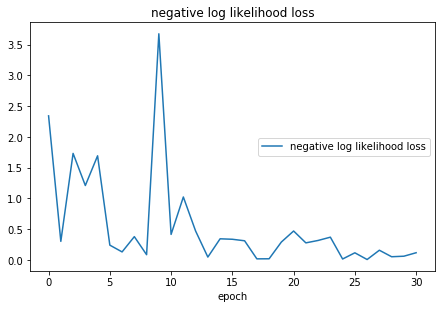

negative log likelihood loss
	negative log likelihood loss 	 (min:    0.007, max:    3.676, cur:    0.117)


In [27]:
from livelossplot import PlotLosses

liveplot = PlotLosses()

for epoch in range(1): 
    for i, (recipe, tags) in enumerate(training_data):
        
        model.zero_grad()
        
        encoded_recipe = converter.words_to_index(recipe) # слово -> его номер в словаре 
        encoded_tags   = converter.tags_to_index(tags)    # тэг   -> его номер в списке тэгов
        
        tag_scores     = model(encoded_recipe)

        loss = loss_function(tag_scores, encoded_tags)
        loss.backward()
        optimizer.step()
        
        
        if i % 500 == 0:
            liveplot.update({'negative log likelihood loss': loss})
            liveplot.draw()
            
            
        if i == 15000:
            break

In [28]:
def predict_tags(model, converter, recipe):
    
    encoded_recipe = converter.words_to_index(recipe)        # слово -> его номер в словаре
    
    encoded_tags   = model.predict_tags(encoded_recipe)      # предсказанные тэги (номера)

    decoded_tags   = converter.indices_to_tags(encoded_tags) # номер тэга -> тэг
    
    return decoded_tags

In [29]:
for i in range(0,10):

    recipe, tags = test_data[np.random.randint(0,7000)]
    
    tags_pred    = predict_tags(model, converter, recipe)

    print('истинные тэги:')
    show_markup(recipe, tags)

    print('предсказанные тэги:')
    show_markup(recipe, tags_pred)
    print()

истинные тэги:


BoxMarkup('1/2 cup lemon juice',
          [Span(0, 3, 'QTY'), Span(4, 7, 'UNIT'), Span(8, 19, 'NAME')])

предсказанные тэги:


BoxMarkup('1/2 cup lemon juice',
          [Span(0, 3, 'QTY'), Span(4, 7, 'UNIT'), Span(8, 19, 'NAME')])


истинные тэги:


BoxMarkup('1 teaspoon ground cumin',
          [Span(0, 1, 'QTY'),
           Span(2, 10, 'UNIT'),
           Span(11, 17, 'COMMENT'),
           Span(18, 23, 'NAME')])

предсказанные тэги:


BoxMarkup('1 teaspoon ground cumin',
          [Span(0, 1, 'QTY'),
           Span(2, 10, 'UNIT'),
           Span(11, 17, 'COMMENT'),
           Span(18, 23, 'NAME')])


истинные тэги:


BoxMarkup('1 envelope unflavored gelatin',
          [Span(0, 1, 'QTY'),
           Span(2, 10, 'UNIT'),
           Span(11, 21, 'COMMENT'),
           Span(22, 29, 'NAME')])

предсказанные тэги:


BoxMarkup('1 envelope unflavored gelatin',
          [Span(0, 1, 'QTY'),
           Span(2, 10, 'UNIT'),
           Span(11, 21, 'COMMENT'),
           Span(22, 29, 'NAME')])


истинные тэги:


BoxMarkup('1 tablespoon onion powder',
          [Span(0, 1, 'QTY'), Span(2, 12, 'UNIT'), Span(13, 25, 'NAME')])

предсказанные тэги:


BoxMarkup('1 tablespoon onion powder',
          [Span(0, 1, 'QTY'), Span(2, 12, 'UNIT'), Span(13, 25, 'NAME')])


истинные тэги:


BoxMarkup('2 teaspoons Chinese five-spice powder',
          [Span(0, 1, 'QTY'), Span(2, 11, 'UNIT'), Span(12, 37, 'NAME')])

предсказанные тэги:


BoxMarkup('2 teaspoons Chinese five-spice powder',
          [Span(0, 1, 'QTY'), Span(2, 11, 'UNIT'), Span(12, 37, 'NAME')])


истинные тэги:


BoxMarkup('Zest from 1 orange',
          [Span(0, 9, 'COMMENT'), Span(10, 11, 'QTY'), Span(12, 18, 'NAME')])

предсказанные тэги:


BoxMarkup('Zest from 1 orange',
          [Span(0, 4, 'OTHER'),
           Span(5, 9, 'COMMENT'),
           Span(10, 11, 'QTY'),
           Span(12, 18, 'NAME')])


истинные тэги:


BoxMarkup('2 tablespoons Chinese black rice vinegar',
          [Span(0, 1, 'QTY'), Span(2, 13, 'UNIT'), Span(14, 40, 'NAME')])

предсказанные тэги:


BoxMarkup('2 tablespoons Chinese black rice vinegar',
          [Span(0, 1, 'QTY'), Span(2, 13, 'UNIT'), Span(14, 40, 'NAME')])


истинные тэги:


BoxMarkup('1/2 teaspoon sea salt',
          [Span(0, 3, 'QTY'),
           Span(4, 12, 'UNIT'),
           Span(13, 16, 'COMMENT'),
           Span(17, 21, 'NAME')])

предсказанные тэги:


BoxMarkup('1/2 teaspoon sea salt',
          [Span(0, 3, 'QTY'), Span(4, 12, 'UNIT'), Span(13, 21, 'NAME')])


истинные тэги:


BoxMarkup('1 cup chopped green pepper',
          [Span(0, 1, 'QTY'),
           Span(2, 5, 'UNIT'),
           Span(6, 13, 'COMMENT'),
           Span(14, 26, 'NAME')])

предсказанные тэги:


BoxMarkup('1 cup chopped green pepper',
          [Span(0, 1, 'QTY'),
           Span(2, 5, 'UNIT'),
           Span(6, 19, 'COMMENT'),
           Span(20, 26, 'NAME')])


истинные тэги:


BoxMarkup('1/2 teaspoon vegetable oil',
          [Span(0, 3, 'QTY'), Span(4, 12, 'UNIT'), Span(13, 26, 'NAME')])

предсказанные тэги:


BoxMarkup('1/2 teaspoon vegetable oil',
          [Span(0, 3, 'QTY'), Span(4, 12, 'UNIT'), Span(13, 26, 'NAME')])

### Save & Load model

In [30]:
'''
torch.save(model.state_dict(), 'models/recipe.pt')
model = LSTMTagger(EMBEDDING_DIM, HIDDEN_DIM, VOCAB_SIZE, TAGSET_SIZE)

model.load_state_dict(torch.load('models/recipe.pt'))
model.eval()


recipe, tags = test_data[4444]

tags_pred = predict_tags(model, recipe)

print('ground truth:')
print(list(zip(recipe, tags)))
print()

print('prediction:')
print(list(zip(recipe, tags_pred)))   


print('ground truth:')
show_markup(recipe, tags)

print('prediction:')
show_markup(recipe, tags_pred)
'''
print()

## Проверка возможностей нейросети на тестовых данных:

### Количество верно предсказанных тэгов:

In [31]:
total_correct, total_tags = tag_statistics(model, converter, test_data)


print('Статистика верно предсказанных тэгов:\n')

for tag in total_tags.keys():
    print('для {}:'.format(tag))
    print('  корректно:\t', total_correct[tag])
    print('      всего:\t',   total_tags[tag])
    print('% корректно:\t', 100 * (total_correct[tag] / float(total_tags[tag])))
    print()

print('----------')
print('в итоге:')
print('  корректно:\t', sum(total_correct.values()))
print('      всего:\t', sum(total_tags.values()))
print('% корректно:\t', 100 * (sum(total_correct.values()) / sum(total_tags.values())))

Статистика верно предсказанных тэгов:

для B-QTY:
  корректно:	 8266
      всего:	 8420
% корректно:	 98.1710213776722

для B-COMMENT:
  корректно:	 5366
      всего:	 7823
% корректно:	 68.59261153010354

для B-RANGE_END:
  корректно:	 113
      всего:	 156
% корректно:	 72.43589743589743

для B-UNIT:
  корректно:	 6787
      всего:	 7074
% корректно:	 95.94288945433985

для B-NAME:
  корректно:	 8728
      всего:	 10278
% корректно:	 84.91924498929752

для I-NAME:
  корректно:	 4336
      всего:	 5528
% корректно:	 78.43704775687411

для I-COMMENT:
  корректно:	 13713
      всего:	 14984
% корректно:	 91.51761879337961

для OTHER:
  корректно:	 1964
      всего:	 4101
% корректно:	 47.89075835162156

----------
в итоге:
  корректно:	 49273
      всего:	 58364
% корректно:	 84.42361729833459


### Матрица Ошибок (Confusion Matrix)

In [32]:
y_pred = []
y_true = []

for recipe, tags in test_data:
    y_pred += predict_tags(model,converter, recipe)
    y_true += tags

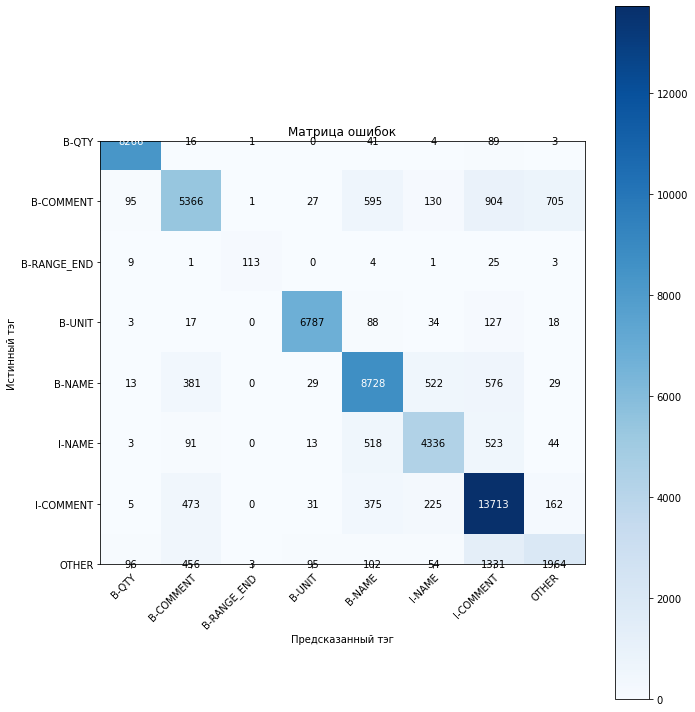

In [33]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), title='Матрица ошибок')

plt.show()

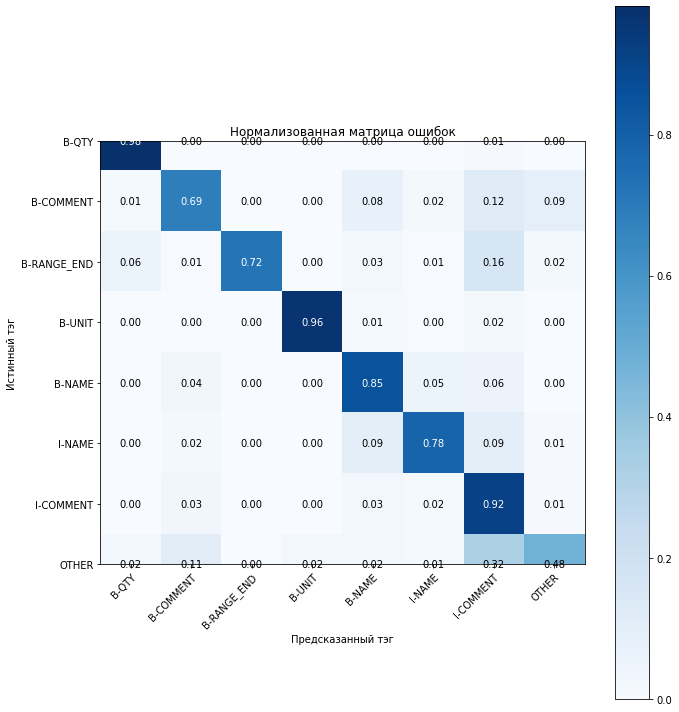

In [34]:
plot_confusion_matrix(y_true, y_pred, classes=list(total_tags.keys()), normalize=True, 
                      title='Нормализованная матрица ошибок')

plt.show()

### Количество верно размеченных рецептов:

In [35]:
correct_recipes, total_recipes = recipe_statistics(model, converter, test_data, 4)

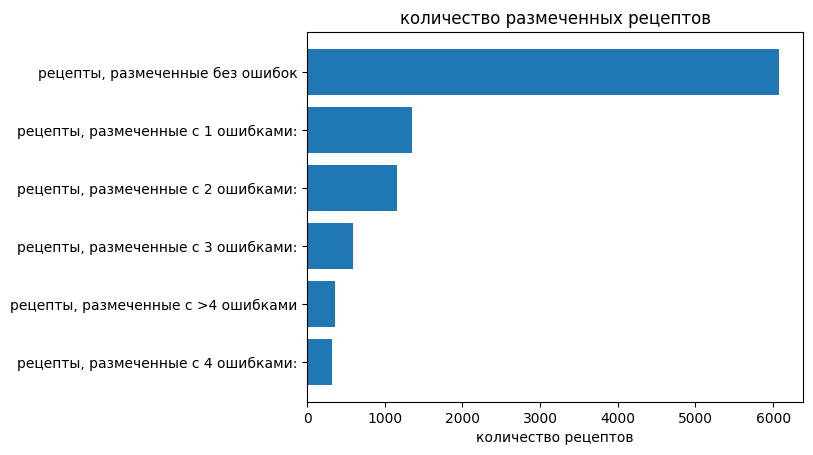

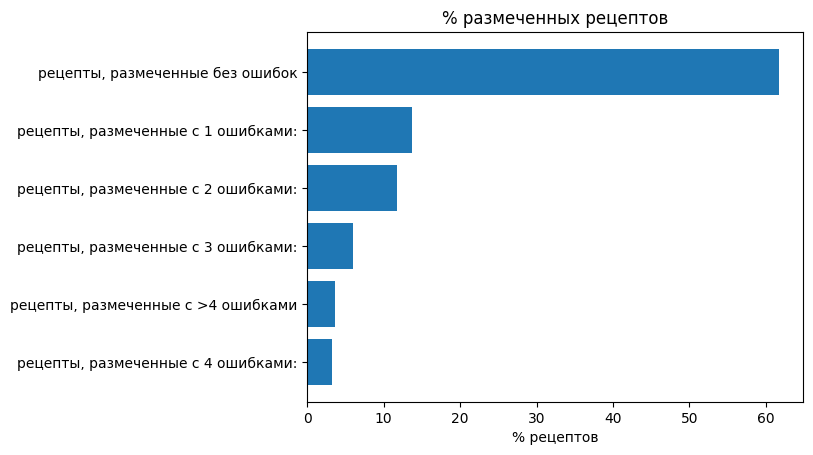

In [36]:
plot_recipe_statistics(correct_recipes)
plot_recipe_statistics(correct_recipes, total_recipes)